# Node2Vec Preparation


In [1]:
import csv

In [2]:
def format_edgelist(edgelist_filename: str, output_filename: str):
    with open(edgelist_filename, 'r', encoding='utf-8') as readfile:
        csv_reader = csv.reader(readfile)
        next(csv_reader)

        with open(output_filename, 'w', encoding='utf-8') as writefile:
            for row in csv_reader:
                source = row[0]
                target = row[1]
                weight = float(row[2])
                output_string = '\t'.join(map(str, [source, target, weight]))
                writefile.write(f"{output_string}\n")

In [4]:
edgelist_filename = "../data/too_big/all_games_filtered.csv"
output_filename = "../data/too_big/all_games_filtered.edgelist"
format_edgelist(edgelist_filename, output_filename)

# Embedding Generation

This implementation of node2vec can be found [here](https://pecanpy.readthedocs.io/en/latest/pecanpy.html#module-pecanpy.pecanpy). The method of generating the embeddings is based on [this](https://github.com/krishnanlab/PecanPy/blob/master/src/pecanpy/cli.py#L334).

In [62]:
#%pip install pecanpy ipywidgets
from pecanpy import pecanpy as node2vec
from gensim.models import Word2Vec, KeyedVectors

In [63]:
def generate_embeddings(input_edgelist: str, output_filename: str, p=1, q=1, num_dimensions=16, num_walks=10, walk_length=80):
    window_size = 10
    num_workers = 0
    num_epochs = 1
    random_state = 0

    g = node2vec.SparseOTF(p=p, q=q, workers=0, verbose=True)
    g.read_edg(input_edgelist, weighted=True, directed=True)
    walks = g.simulate_walks(num_walks, walk_length)
    model = Word2Vec(
        walks,
        vector_size=num_dimensions,
        window=window_size,
        min_count=0,
        sg=1,
        workers=num_workers,
        epochs=num_epochs,
        seed=random_state,
    )
    
    model.wv.save_word2vec_format(output_filename)

In [111]:
# Generate the embeddings using an edgelist.
input_edgelist = "../data/too_big/all_games_filtered.edgelist"
output_filename = "./all_games.emb"
generate_embeddings(input_edgelist, output_filename,
                    p=0.25, q=1, num_dimensions=128)


  0%|          | 0/304330 [00:00<?, ?it/s]

# Node2Vec Analysis

In this notebook, we are using the graph embeddings generated from `node2vec` to discover deeper insight from the graph created by `data/games/network/all_games.csv`.

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

In [122]:
homophily_embeddings = "../data/games/network/all_games_homophily.emb"
structural_equivalence_embeddings = "../data/games/network/all_games_structural_equivalence.emb"
test_embeddings = "./all_games.emb"

homophily_df = pd.read_csv(homophily_embeddings, delimiter=" ", skiprows=1, index_col=0, header=None).add_prefix("dim_")
structural_equivalence_df = pd.read_csv(structural_equivalence_embeddings, delimiter=" ", skiprows=1, index_col=0, header=None).add_prefix("dim_")
test_df = pd.read_csv(test_embeddings, delimiter=" ", skiprows=1, index_col=0, header=None).add_prefix("dim_")

## Node Similarity

In [113]:
import pandas as pd
from gensim.models import KeyedVectors

def get_vectors_from_embeddings(input_embeddings_filename: str):
    return KeyedVectors.load_word2vec_format(input_embeddings_filename, binary=False)

def format_games_metadata_dataframe(df: pd.DataFrame):
    # Remove row if game do not have a created date.
    df.drop(df[df['created_date'] == 'None'].index, inplace=True)

    # Remove rows with N/As in them.
    df = df.dropna()

    # Format the release_date and created_date to be an actual date type.
    df['release_date'] = pd.to_datetime(df['release_date'])
    df['created_date'] = pd.to_datetime(
        df['created_date'], format='%Y-%m-%dT%H:%M:%SZ')
    df['release_date'] = pd.to_datetime(
        df['release_date'].dt.strftime('%Y-%m-%d'))
    df['created_date'] = pd.to_datetime(
        df['created_date'].dt.strftime('%Y-%m-%d'))

    # Remove rows with a created date or release date before cutoff.
    df = df[(df['created_date'] < '2023-01-01') &
            (df['release_date'] < '2023-01-01')]

    # Format numeric data into a numeric data type.
    df[['num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']] = df[[
        'num_categories', 'num_levels', 'num_runs', 'num_users', 'num_guests']].apply(pd.to_numeric)

    # Rename the game_id column to just id.
    df.rename(columns={'game_id': 'id'}, inplace=True)

    return df

def find_most_similar_games(game_id: str, node_vectors: KeyedVectors, metadata_df: pd.DataFrame) -> pd.DataFrame:
    most_similar = node_vectors.most_similar(game_id)
    most_similar_df = pd.DataFrame(most_similar)
    most_similar_df.rename(columns={0: 'id', 1: 'similarity_value'}, inplace=True)
    return metadata_df.merge(most_similar_df, on='id', how='inner').sort_values(by='similarity_value', ascending=False)


In [114]:
node_vectors = get_vectors_from_embeddings(test_embeddings)
games_metadata_df = pd.read_csv("../data/games/metadata/all_games.csv")
games_metadata_df = format_games_metadata_dataframe(games_metadata_df)

In [123]:
game_id = "o1y9okr6"
most_similar_df = find_most_similar_games(game_id, node_vectors, games_metadata_df)
most_similar_df

,id,game_name,developers,release_date,created_date,num_categories,num_levels,num_runs,num_users,num_guests,similarity_value
7,46w2r4q6,Generator,None,2020-10-29,2021-07-22,2,0,3,2,0,0.370888
5,lde372e6,CircloO,None,2017-03-01,2021-03-03,7,23,270,50,1,0.345669
9,m1zkww01,Pizza Death,None,2022-07-09,2022-07-22,1,0,10,5,0,0.320453
1,k6qwgo96,NHL 2K2,None,2002-02-14,2022-06-28,5,0,6,3,0,0.319842
0,268epp96,Space Invaders '91,nw633p6x,1990-09-07,2018-04-13,1,0,1,1,0,0.317740
6,k6q4l90d,Fireblob,1zk38pej,2019-05-01,2020-07-01,1,0,24,14,1,0.315883
8,76r32w56,Pokémon Mystery Dungeon: Ace Attorney,None,2021-12-26,2022-05-09,1,0,1,1,0,0.313106
3,268qpk6p,Ben 10 Alien Force: Forever Defense,None,2010-04-23,2017-05-14,3,0,12,6,0,0.306963
4,lde83xd3,Deepest Sleep,4zw1d26k,2014-01-01,2017-05-07,2,0,6,5,0,0.306490
2,o1y9jnr6,Inspector Ooh: The Great Monkey Detective,ge0n1xzp,2005-07-15,2018-01-23,6,0,64,22,0,0.305610


In [116]:
print(f"Distance: {node_vectors.distance('o1y9wo6q', 'o1ymwk1q')}, Similarity: {node_vectors.similarity('o1y9wo6q', 'o1ymwk1q')}")
print(f"Distance: {node_vectors.distance('o1y9wo6q', 'y654y5ed')}, Similarity: {node_vectors.similarity('o1y9wo6q', 'y654y5ed')}")

Distance: 1.1440393924713135, Similarity: -0.14403939247131348
Distance: 0.9660726562142372, Similarity: 0.03392734378576279


## PCA and Clustering

In [137]:
df = structural_equivalence_df.copy()

### Principal Component Analysis

(30433, 2)


/var/folders/fp/pwtrzcy130zdfcx62mp9_kmc0000gn/T/ipykernel_14045/3263313483.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(transformed_df[:,0],transformed_df[:,1],cmap='plasma')


Text(0, 0.5, 'pc2')

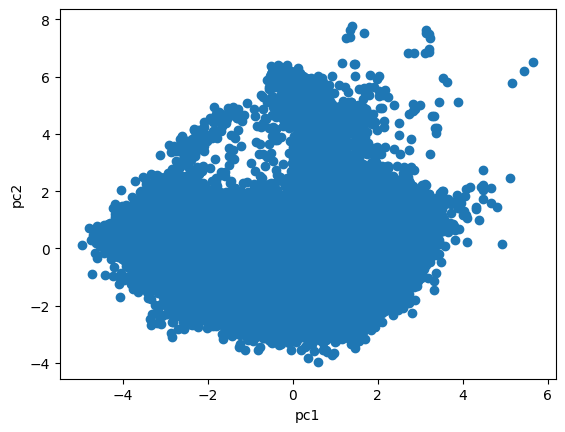

In [138]:
#%pip install scikit-learn scipy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

number_of_components = 2

scaled_df = StandardScaler().fit_transform(df)
pca = PCA(number_of_components)
transformed_df = pca.fit_transform(scaled_df)

print(transformed_df.shape)

plt.scatter(transformed_df[:,0],transformed_df[:,1],cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

### K-Means Clustering

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


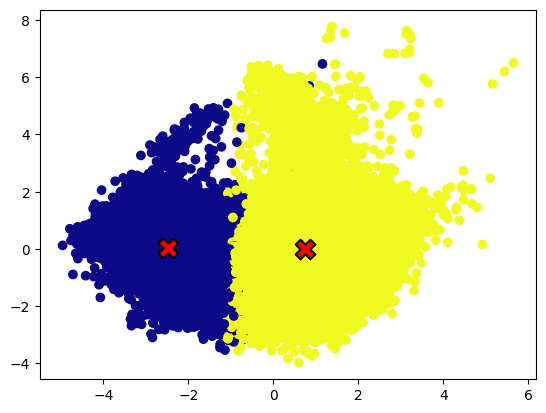

In [139]:
from sklearn.cluster import KMeans

number_of_clusters = 2

kmeans = KMeans(n_clusters=number_of_clusters, random_state=0)
kmeans.fit(scaled_df)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(transformed_df[:, 0],transformed_df[:, 1],c=labels,cmap='plasma')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)
plt.show()

### Hyper Parameter Tuning K-Means Clustering

Most of this subsection is taken from [here](https://github.com/Shivangi0503/Wine_Clustering_KMeans/blob/main/WineClustering.py).

In [120]:
from sklearn.model_selection import ParameterGrid
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [140]:
parameters = [2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40]
parameter_grid = ParameterGrid({'n_clusters': parameters})
  
best_score = -1
kmeans_model = KMeans(n_init='auto')
silhouette_scores = []

for p in parameter_grid:
    kmeans_model.set_params(**p)
    kmeans_model.fit(scaled_df)
    ss = metrics.silhouette_score(scaled_df, kmeans_model.labels_)
    silhouette_scores += [ss]
    if ss > best_score:
        best_score = ss
        best_grid = p

best_number_of_clusters = best_grid['n_clusters']
print(best_number_of_clusters)

3


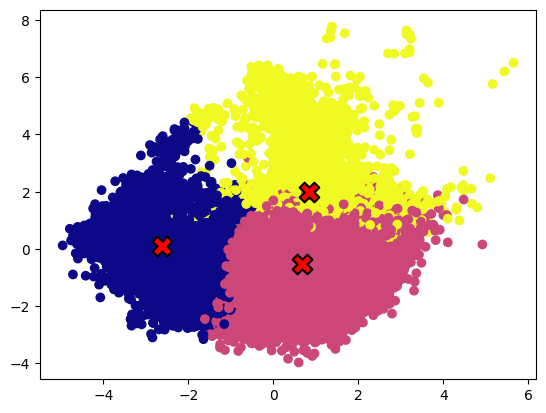

In [141]:
kmeans = KMeans(n_clusters=best_number_of_clusters, random_state=0, n_init='auto')
kmeans.fit(scaled_df)

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
centroids_pca = pca.transform(centroids)
plt.scatter(transformed_df[:,0],transformed_df[:,1],c=labels,cmap='plasma')
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)
plt.show()

In [36]:
cluster_df = pd.DataFrame()
cluster_df['id'] = df.index.values
cluster_df['cluster_num'] = kmeans.labels_
cluster_df = cluster_df.set_index('id')
cluster_df[(cluster_df['cluster_num'] == 0)]

In [37]:
cluster_df.to_csv("../data/games/network/all_games_homophily_clusters.csv")